## DeepSruv-TF demo for simulated linear and non-linear data

In [1]:
# Set environment variable
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple GPUs
# impoart tensorflow
import tensorflow as tf
print(tf.__version__)
# Allow growing memmory 
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

1.10.0


### Import DeepSurv packages

In [2]:
import sys
sys.path.append("deepsurv")
import deepsurv_tf
import deepsurv

### Import utility packages

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import seaborn as sns
import pandas
import h5py as h5

In [4]:
import sys
sys.path.append("deepsurv")
import deepsurv_tf
import deepsurv
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas

In [5]:
epochs= 3000

def h5_to_deepsurv_ds(file_, type='train'):
    e = file_[type]['e'].value
    t = file_[type]['t'].value
    x = file_[type]['x'].value

    # Return the deep surv dataframe
    return {
        'x': x,
        'e': e,
        't': t
    }

params = deepsurv_tf.Parameters()
params.n_epochs = epochs

out/learned.model


### Simulatd linear survival data

Training done
Best epoch 970
Best loss 3024.0417


INFO:tensorflow:Restoring parameters from out/learned.model


/home/tuemura/.virtualenvs/Adv_Surv-py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


model loaded
test CI: 0.7631140760507005


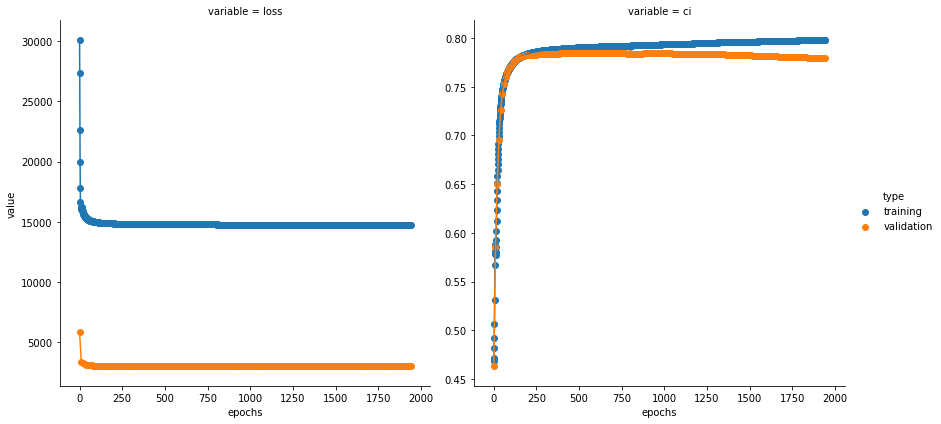

In [6]:
dataset = h5.File("data/linear/linear_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')

params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

test = h5_to_deepsurv_ds(dataset, 'test')
print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))

### Simulated non-linear (Gaussian) survival data

Training done
Best epoch 2990
Best loss 3238.047


INFO:tensorflow:Restoring parameters from out/learned.model


/home/tuemura/.virtualenvs/Adv_Surv-py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


model loaded
test CI: 0.6299226150767178


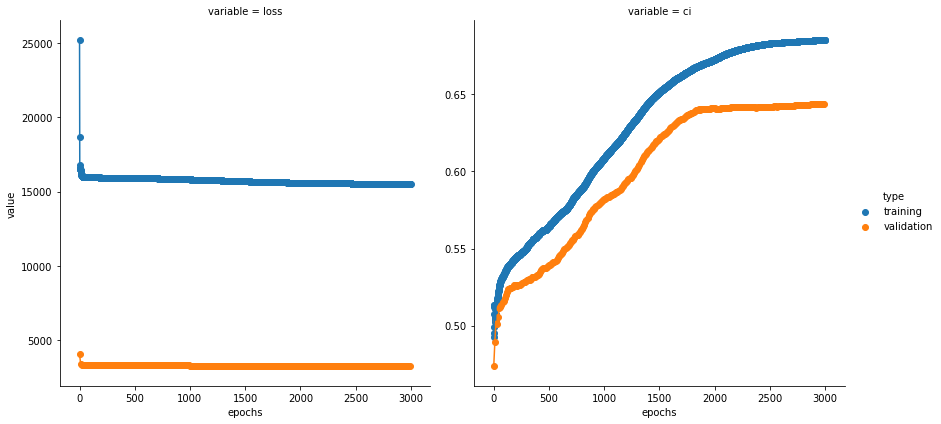

In [7]:
dataset = h5.File("data/gaussian/gaussian_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')

params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

test = h5_to_deepsurv_ds(dataset, 'test')
print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))